In [1]:
import os
import ast
import h5py
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from scipy.spatial import KDTree
import networkx as nx


The model running cell already has torch.load method loading the dataset but this part can be used for some visualization pre training.

In [38]:
import torch
save_dir = "data"
# File path to load the graph data
load_path = os.path.join(save_dir, "graph_data_augmented.pt")

# Load the graph data
loaded_data = torch.load(load_path)
print(f"Graph data loaded from {load_path}")

# Access the loaded data
nodes = loaded_data["nodes"]
edge_index = loaded_data["edge_index"]
leaf_labels = loaded_data["leaf_labels"]
genus_labels = loaded_data["genus_labels"]
species_labels = loaded_data["species_labels"]

print("Nodes shape:", nodes.shape)
print("Edge index shape:", edge_index.shape)

Graph data loaded from data\graph_data_augmented.pt
Nodes shape: torch.Size([35995, 2625])
Edge index shape: torch.Size([2, 107933])


In [39]:
print("Leaf labels shape:", leaf_labels.shape)
print("Genus labels shape:", genus_labels.shape)
print("Species labels shape:", species_labels.shape)


Leaf labels shape: torch.Size([35965])
Genus labels shape: torch.Size([35965])
Species labels shape: torch.Size([35965])


In [40]:
# Split data into training and testing sets
train_idx, test_idx = train_test_split(np.arange(loaded_data["leaf_labels"].shape[0]), test_size=0.2, random_state=42)
print("Train indices:", train_idx.max(), test_idx.max())
x_train = loaded_data["nodes"][train_idx]
x_test = loaded_data["nodes"][test_idx]
edge_index = loaded_data["edge_index"]
leaf_labels_train = loaded_data["leaf_labels"][train_idx]
leaf_labels_test = loaded_data["leaf_labels"][test_idx]
genus_labels_train = loaded_data["genus_labels"][train_idx]
genus_labels_test = loaded_data["genus_labels"][test_idx]
species_labels_train = loaded_data["species_labels"][train_idx]
species_labels_test = loaded_data["species_labels"][test_idx]

Train indices: 35964 35959


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
"""
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
       """ """ GCNConv layers """ """
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)"""

The base GCN model should be run before the cell below.

In [6]:
class TreeGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(TreeGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return x

In [4]:
import torch
import torch.nn.functional as F

class HierarchicalLoss(torch.nn.Module):
    def __init__(self, hierarchy):
        """
        Args:
            hierarchy (dict): A dictionary representing the hierarchy.
                              For example:
                              {
                                  "species": {"genus": 0.5, "leaf": 0.2},
                                  "genus": {"leaf": 0.3},
                                  "leaf": {}
                              }
        """
        super(HierarchicalLoss, self).__init__()
        self.hierarchy = hierarchy

    def forward(self, predictions, targets, node_types):
        """
        Args:
            predictions (torch.Tensor): Model predictions (logits), shape [batch_size, num_classes].
            targets (torch.Tensor): Ground truth labels, shape [batch_size].
            node_types (list): List of node types (e.g., "species", "genus", "leaf") corresponding to each sample.
        
        Returns:
            torch.Tensor: Computed hierarchical loss.
        """
        batch_size = predictions.shape[0]
        loss = 0.0

        for i in range(batch_size):
            pred = predictions[i]
            target = targets[i]
            node_type = node_types[i]

            # Cross-entropy loss for the current node
            ce_loss = F.cross_entropy(pred.unsqueeze(0), target.unsqueeze(0))

            # Hierarchical penalties
            penalty = 0.0
            for parent, weight in self.hierarchy.get(node_type, {}).items():
                if parent in node_types:  # Ensure parent type is in the dataset
                    parent_index = node_types.index(parent)
                    if targets[parent_index] == target:  # Check if parent matches the target
                        penalty += weight

            # Combine the cross-entropy loss and the hierarchical penalty
            loss += ce_loss * (1 - penalty)

        return loss / batch_size


This is the main GCN model.

Epoch 1/100 
Train Acc: 0.0389, Test Acc: 0.0412
Epoch 2/100 
Train Acc: 0.2134, Test Acc: 0.2135
Epoch 3/100 
Train Acc: 0.2808, Test Acc: 0.2819
Epoch 4/100 
Train Acc: 0.3085, Test Acc: 0.3039
Epoch 5/100 
Train Acc: 0.3273, Test Acc: 0.3270
Epoch 6/100 
Train Acc: 0.3488, Test Acc: 0.3440
Epoch 7/100 
Train Acc: 0.3622, Test Acc: 0.3615
Epoch 8/100 
Train Acc: 0.3738, Test Acc: 0.3703
Epoch 9/100 
Train Acc: 0.3789, Test Acc: 0.3777
Epoch 10/100 
Train Acc: 0.3849, Test Acc: 0.3849
Epoch 11/100 
Train Acc: 0.3998, Test Acc: 0.4028
Epoch 12/100 
Train Acc: 0.4170, Test Acc: 0.4179
Epoch 13/100 
Train Acc: 0.4292, Test Acc: 0.4307
Epoch 14/100 
Train Acc: 0.4433, Test Acc: 0.4471
Epoch 15/100 
Train Acc: 0.4556, Test Acc: 0.4576
Epoch 16/100 
Train Acc: 0.4649, Test Acc: 0.4698
Epoch 17/100 
Train Acc: 0.4733, Test Acc: 0.4757
Epoch 18/100 
Train Acc: 0.4830, Test Acc: 0.4841
Epoch 19/100 
Train Acc: 0.4907, Test Acc: 0.4902
Epoch 20/100 
Train Acc: 0.4964, Test Acc: 0.4963
Epoch 21/

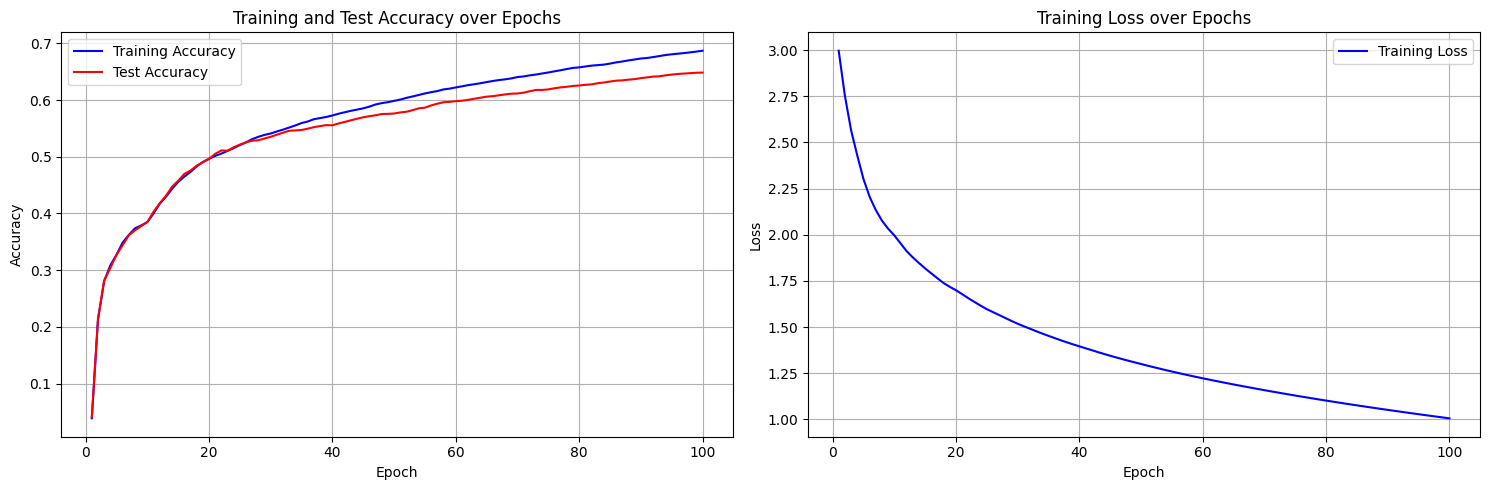

Final Training Accuracy: 0.6869
Final Test Accuracy: 0.6483
Final Model Accuracy: 0.6492


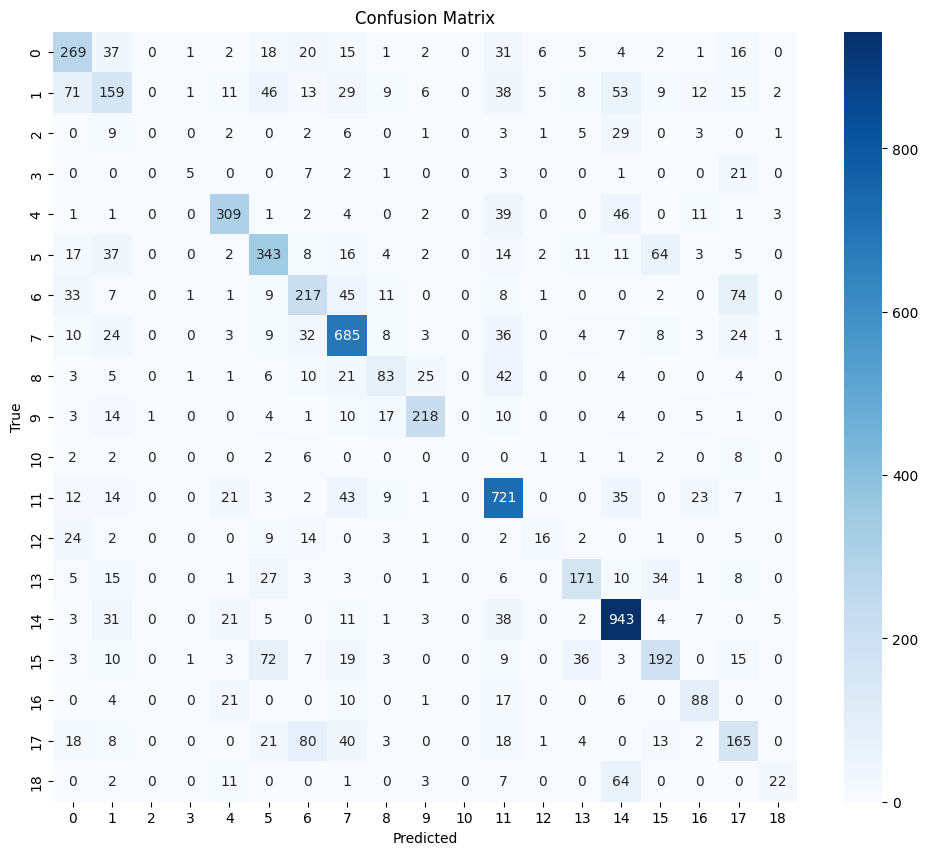

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch.optim as optim

save_dir = "data"
# Load the graph data
load_path = os.path.join(save_dir, "graph_data_augmented.pt")
loaded_data = torch.load(load_path)

# Get the number of nodes from species labels
num_nodes = loaded_data["species_labels"].shape[0]

# Ensure all tensors have consistent dimensions
nodes = loaded_data["nodes"][:num_nodes]
species_labels = loaded_data["species_labels"][:num_nodes]

# Filter edge_index to only include valid node indices
valid_edges_mask = (loaded_data["edge_index"][0] < num_nodes) & (loaded_data["edge_index"][1] < num_nodes)
filtered_edge_index = loaded_data["edge_index"][:, valid_edges_mask]

# Create a PyTorch Geometric Data object
data = Data(
    x=nodes,
    edge_index=filtered_edge_index,
    y=species_labels
)
# These hierarchy weights increase the computaiton but they are influencing the loss function during the training e.g. if the genus type is mis calssfiied within correct leaf tyoe that is penalised less then otherwise.
hierarchy = {
    "species": {"genus": 0.5, "leaf": 0.2},
    "genus": {"leaf": 0.3},
    "leaf": {}
}

hierarchical_loss_fn = HierarchicalLoss(hierarchy)

#  Here defining the model, optimizer, and loss function
input_dim = data.x.shape[1]
hidden_dim = 64
num_classes = len(torch.unique(loaded_data["species_labels"]))
model = TreeGNN(input_dim, hidden_dim, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

node_types = loaded_data["nodes"][:num_nodes]  # Ensuring consistent dimensions

# Split data into training and test sets
train_mask = torch.rand(data.x.shape[0]) < 0.8
test_mask = ~train_mask

# Initialize lists to store metrics
train_accs = []
test_accs = []
train_losses = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    #loss = loss_fn(out[train_mask], data.y[train_mask])
    loss = hierarchical_loss_fn(out[train_mask], data.y[train_mask], [node_types[i] for i in train_mask.nonzero(as_tuple=True)[0].tolist()])
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs} ")
    
    # training accuracy 
    train_pred = out[train_mask].argmax(dim=1)
    train_acc = (train_pred == data.y[train_mask]).float().mean()
    # test accuracy
    test_pred = out[test_mask].argmax(dim=1) 
    test_acc = (test_pred == data.y[test_mask]).float().mean()
    
    # The metrics
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
    train_losses.append(loss.item())
    
    print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# Evaluation of the model
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[test_mask] == data.y[test_mask]).sum()
    accuracy = int(correct) / int(test_mask.sum())
    print(f"Test Accuracy: {accuracy:.4f}")

# Prediction
def predict(model, data, node_idx):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[node_idx].argmax(dim=0)
    return pred.item()

# This is not necessary, just checking for myself
# Example prediction for a specific node
node_idx = 0  # Change this to the index of the node you want to predict
predicted_species = predict(model, data, node_idx)
print(f"Predicted species for node {node_idx}: {predicted_species}")

# Create subplots for metrics
plt.figure(figsize=(15, 5))

# Plot accuracies
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs+1), test_accs, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, color='blue', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Model Accuracy: {accuracy:.4f}")

# Get predictions for all data points
model.eval()
with torch.no_grad():
    all_predictions = model(data.x, data.edge_index).argmax(dim=1)

# Calculate confusion matrix for test data
cm = confusion_matrix(data.y[test_mask].cpu(), all_predictions[test_mask].cpu())

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


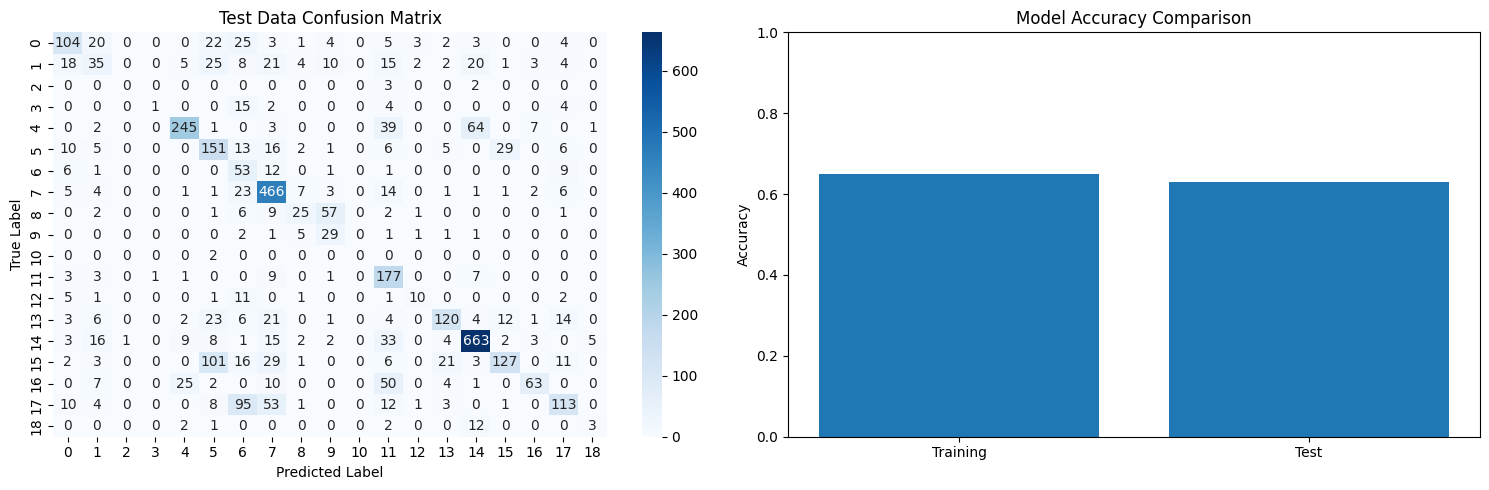

Test Accuracy: 0.6290

Classificationb Report:
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       196
           1       0.32      0.20      0.25       173
           2       0.00      0.00      0.00         5
           3       0.50      0.04      0.07        26
           4       0.84      0.68      0.75       362
           5       0.44      0.62      0.51       244
           6       0.19      0.64      0.30        83
           7       0.70      0.87      0.77       535
           8       0.51      0.24      0.33       104
           9       0.27      0.71      0.39        41
          10       0.00      0.00      0.00         2
          11       0.47      0.88      0.61       202
          12       0.56      0.31      0.40        32
          13       0.74      0.55      0.63       217
          14       0.85      0.86      0.86       767
          15       0.73      0.40      0.52       320
          16       0.80      0.39 

In [12]:
# Load test data
test_path = os.path.join(save_dir, "graph_data_test.pt")
test_data = torch.load(test_path)
# Ensure the test data has consistent sizes between nodes and species_labels
valid_size = min(test_data["nodes"].shape[0], test_data["species_labels"].shape[0])
test_data["nodes"] = test_data["nodes"][:valid_size]
test_data["species_labels"] = test_data["species_labels"][:valid_size]
# Filter edge_index to only include valid node indices
valid_edges_mask = (test_data["edge_index"][0] < valid_size) & (test_data["edge_index"][1] < valid_size)
test_data["edge_index"] = test_data["edge_index"][:, valid_edges_mask]

# Ensure model is in evaluation mode
model.eval()


with torch.no_grad():
    # Get predictions on test data
    test_out = model(test_data["nodes"], test_data["edge_index"])
    test_predictions = test_out.argmax(dim=1)
    
    # Calculate accuracy
    min_size = min(test_predictions.shape[0], test_data["species_labels"].shape[0])
    test_predictions = test_predictions[:min_size]
    test_labels = test_data["species_labels"][:min_size]
    
    test_accuracy = (test_predictions == test_labels).float().mean()
    
    # Create confusion matrix
    cm_test = confusion_matrix(test_labels.cpu(), test_predictions.cpu())
    
    # Generate classification report
    class_report = classification_report(test_data["species_labels"].cpu(), test_predictions.cpu())

# Plot results
plt.figure(figsize=(15, 5))

# Plot confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Data Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot accuracy comparison
plt.subplot(1, 2, 2)
accuracies = [accuracy, test_accuracy.item()]
plt.bar(['Training', 'Test'], accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Print metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassificationb Report:")
print(class_report)

c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


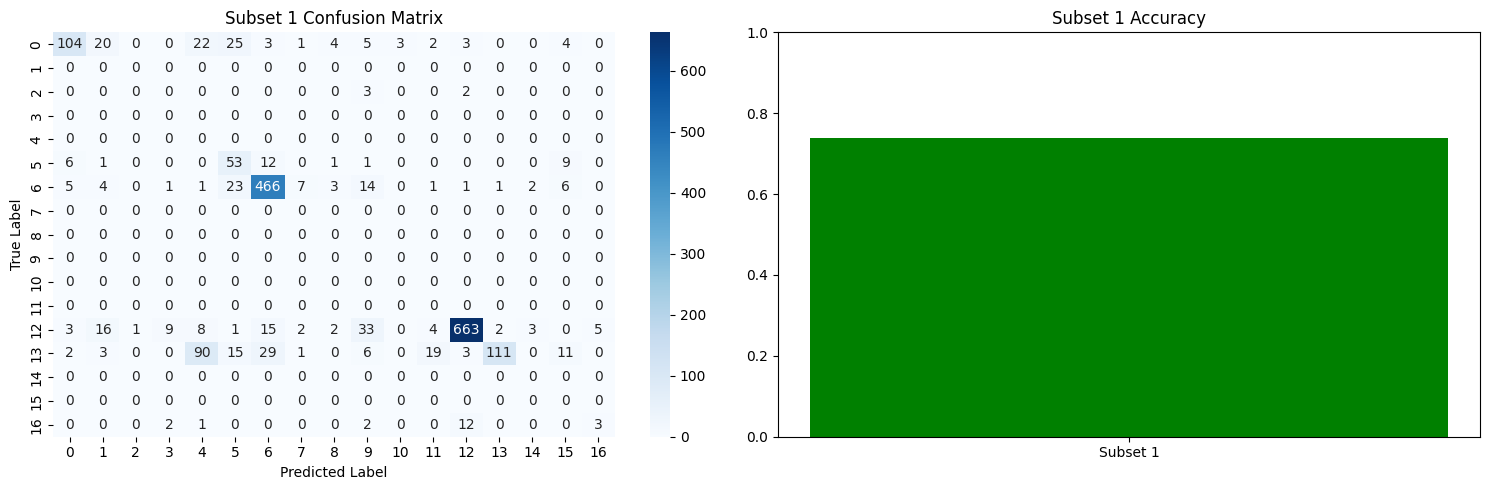

Subset 2 Accuracy: 0.7384
Classification Report (Subset 2):
              precision    recall  f1-score   support

           0       0.87      0.53      0.66       196
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.45      0.64      0.53        83
           7       0.89      0.87      0.88       535
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.97      0.86      0.91       767
          15       0.97      0.38      0.55       290
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.

c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\

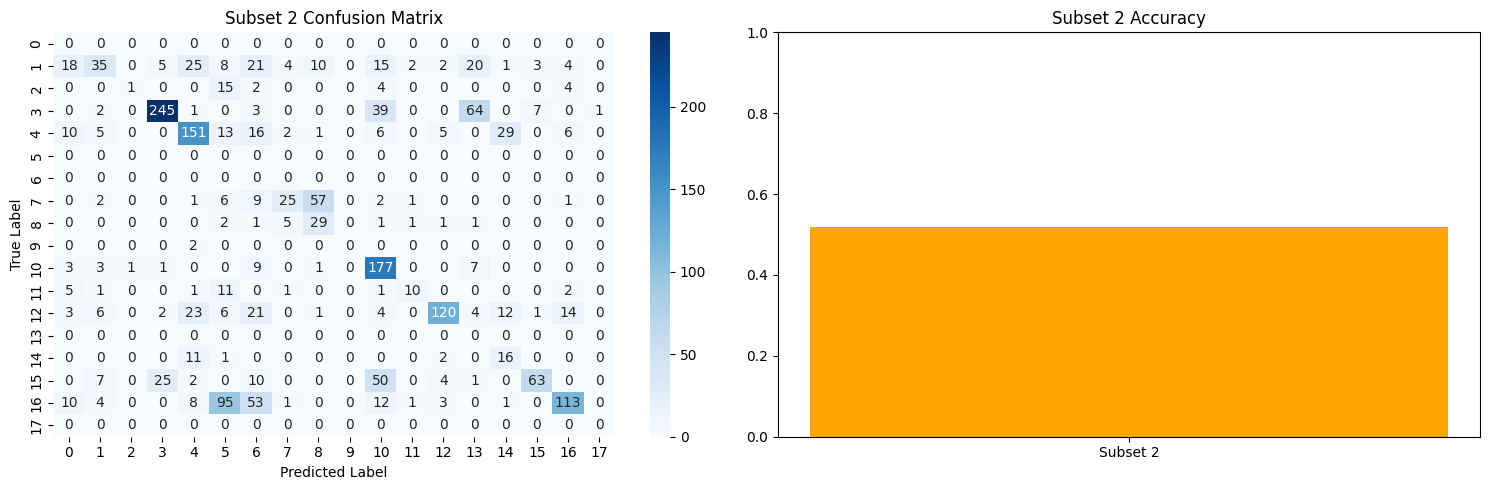

Subset 2 Accuracy: 0.5195
Classification Report (Subset 2):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.54      0.20      0.29       173
           3       0.50      0.04      0.07        26
           4       0.88      0.68      0.77       362
           5       0.67      0.62      0.64       244
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.66      0.24      0.35       104
           9       0.29      0.71      0.41        41
          10       0.00      0.00      0.00         2
          11       0.57      0.88      0.69       202
          12       0.67      0.31      0.43        32
          13       0.88      0.55      0.68       217
          14       0.00      0.00      0.00         0
          15       0.27      0.53      0.36        30
          16       0.85      0.39      0.53       162
          17       0.

In [10]:
import torch
from sklearn.metrics import confusion_matrix, classification_report

# Load test data
test_path = os.path.join(save_dir, "graph_data_test.pt")
test_data = torch.load(test_path)
# Ensure the test data has consistent sizes between nodes and species_labels
valid_size = min(test_data["nodes"].shape[0], test_data["species_labels"].shape[0])
test_data["nodes"] = test_data["nodes"][:valid_size]
test_data["species_labels"] = test_data["species_labels"][:valid_size]

# Ensure model is in evaluation mode
model.eval()
"""
with torch.no_grad():
    # Get predictions on test data
    test_out = model(test_data["nodes"], test_data["edge_index"])
    test_predictions = test_out.argmax(dim=1)
    
    # Calculate accuracy
    min_size = min(test_predictions.shape[0], test_data["species_labels"].shape[0])
    test_predictions = test_predictions[:min_size]
    test_labels = test_data["species_labels"][:min_size]
    
    test_accuracy = (test_predictions == test_labels).float().mean()
    
    # Create confusion matrix
    cm_test = confusion_matrix(test_labels.cpu(), test_predictions.cpu())
    
    # Generate classification report
    class_report = classification_report(test_data["species_labels"].cpu(), test_predictions.cpu())

# Plot results
plt.figure(figsize=(15, 5))

# Plot confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Data Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot accuracy comparison
plt.subplot(1, 2, 2)
accuracies = [accuracy, test_accuracy.item()]
plt.bar(['Training', 'Test'], accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Print metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(class_report)"""
# ---------------------------------------------------------
# Create two different "test" subsets from the original test data
# Let's split the test data into two halves using the valid_size
valid_size = test_data["nodes"].shape[0]
subset_size = valid_size // 2
test_indices_1 = torch.arange(0, subset_size)
test_indices_2 = torch.arange(subset_size, valid_size)
# Let's split the test data into two halves:
subset_size = test_data["nodes"].shape[0] // 2
test_indices_1 = torch.arange(0, subset_size)
test_indices_2 = torch.arange(subset_size, test_data["nodes"].shape[0])

# ---------- Subset 1 -----------
test_nodes_1 = test_data["nodes"][test_indices_1]
test_labels_1 = test_data["species_labels"][test_indices_1]

# Forward pass for subset 1
# Filter edge_index for nodes in subset 1
mask1 = (test_data["edge_index"][0] < subset_size) & (test_data["edge_index"][1] < subset_size)
edge_index_1 = test_data["edge_index"][:, mask1]
test_out_1 = model(test_nodes_1, edge_index_1)

test_predictions_1 = test_out_1.argmax(dim=1)

# Accuracy
acc_1 = (test_predictions_1 == test_labels_1).float().mean()

# Confusion matrix and classification report
cm_test_1 = confusion_matrix(test_labels_1.cpu(), test_predictions_1.cpu())
class_report_1 = classification_report(test_labels_1.cpu(), test_predictions_1.cpu())

# Plotting Subset 1 results
plt.figure(figsize=(15, 5))

# Subset 1 Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm_test_1, annot=True, fmt='d', cmap='Blues')
plt.title('Subset 1 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Subset 1 Accuracy
plt.subplot(1, 2, 2)
plt.bar(['Subset 1'], [acc_1.item()], color='green')
plt.ylim(0, 1)
plt.title('Subset 1 Accuracy')
plt.tight_layout()
plt.show()

print(f"Subset 2 Accuracy: {acc_1:.4f}")
print("Classification Report (Subset 2):")
print(class_report_1)
# ---------- Subset 2 -----------
# Define test_nodes_2 and test_labels_2 for subset 2
test_nodes_2 = test_data["nodes"][test_indices_2]
test_labels_2 = test_data["species_labels"][test_indices_2]
# Forward pass for subset 2
# Filter edge_index for nodes in subset 2 and adjust indices.
mask2 = ((test_data["edge_index"][0] >= subset_size) & (test_data["edge_index"][0] < valid_size) &
         (test_data["edge_index"][1] >= subset_size) & (test_data["edge_index"][1] < valid_size))
edge_index_2 = test_data["edge_index"][:, mask2] - subset_size
test_out_2 = model(test_nodes_2, edge_index_2)
test_predictions_2 = test_out_2.argmax(dim=1)

# Accuracy
acc_2 = (test_predictions_2 == test_labels_2).float().mean()

# Confusion matrix and classification report
cm_test_2 = confusion_matrix(test_labels_2.cpu(), test_predictions_2.cpu())
class_report_2 = classification_report(test_labels_2.cpu(), test_predictions_2.cpu())

# Plotting Subset 2 results
plt.figure(figsize=(15, 5))

# Subset 2 Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm_test_2, annot=True, fmt='d', cmap='Blues')
plt.title('Subset 2 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Subset 2 Accuracy
plt.subplot(1, 2, 2)
plt.bar(['Subset 2'], [acc_2.item()], color='orange')
plt.ylim(0, 1)
plt.title('Subset 2 Accuracy')
plt.tight_layout()
plt.show()

print(f"Subset 2 Accuracy: {acc_2:.4f}")
print("Classification Report (Subset 2):")
print(class_report_2)